In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
from transformers import ViTFeatureExtractor, ViTForImageClassification, ViTImageProcessor

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
os.listdir('/kaggle/input/mydfmsd')

['TestData', 'ValData', 'TrainData']

In [5]:
os.listdir('/kaggle/input/mydfmsd')
train_path = '/kaggle/input/mydfmsd/TrainData'
test_path = '/kaggle/input/mydfmsd/TestData'
val_path = '/kaggle/input/mydfmsd/ValData'

In [6]:
pretrained_model_name = 'google/vit-base-patch16-224-in21k' #'google/vit-base-patch16-224'
# Load pretrained ViT model and feature extractor
model = ViTForImageClassification.from_pretrained(pretrained_model_name)
feature_extractor = ViTImageProcessor.from_pretrained(pretrained_model_name)
# model = ViTForImageClassification.from_pretrained(pretrained_model_name) #, num_labels=3
# feature_extractor = ViTImageProcessor(pretrained_model_name) #, num_labels=3

# Modify the classification head for our Sentiment Classification task
# model.classifier = nn.Linear(in_features = model.config.hidden_size, out_features=2)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [7]:
# # Remove the existing classification head
model.classifier = nn.Identity()

# Add a new binary classification head with a Softmax layer
model.add_module("classifier", nn.Sequential(
    nn.Linear(model.config.hidden_size, out_features=2),
    nn.Softmax(dim=1)
))

In [8]:
model.config.hidden_size

768

In [9]:
from torchinfo import summary
print(model), print(summary(model))

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

(None, None)

In [10]:
feature_extractor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [11]:
transform = transforms.Compose([
    transforms.Resize((feature_extractor.size['height'], feature_extractor.size['width'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
    ])

train_data = datasets.ImageFolder(root=train_path, transform=transform)
test_data = datasets.ImageFolder(root=test_path, transform=transform)
val_data = datasets.ImageFolder(root=val_path, transform=transform)

In [12]:
# Define data loaders with GPU support
train_loader = torch.utils.data.DataLoader(train_data, batch_size=20, shuffle=True, pin_memory=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=20, shuffle=False, pin_memory=True, num_workers=2)

In [13]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6) 

In [14]:
from tqdm import tqdm

model = model.to('cuda')
training_loss_list = []
validation_loss_list = []
accuracy_list = []
tempTrainingLoss = 100

# Fine tune the model
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    with tqdm(train_loader) as tepoch:  
        for inputs, labels in tepoch:
            # Move data to GPU
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            outputs = model(inputs)
            loss = criterion(outputs.logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tepoch.set_postfix({'Training_loss':loss.item()})
            
            tempTrainingLoss = loss.item()
        
        training_loss_list.append(tempTrainingLoss)

        
    # Validate the model
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in val_loader:
            # Move data to GPU
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            outputs = model(inputs)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = correct / total
        print(f'Epoch {epoch+1}/{num_epochs}, Validation_Loss: {val_loss/len(val_loader)}, Accuracy: {accuracy}')

        validation_loss_list.append(val_loss/len(val_loader))
        accuracy_list.append(accuracy)

100%|██████████| 746/746 [04:31<00:00,  2.75it/s, Training_loss=0.652]


Epoch 1/15, Validation_Loss: 0.6852332167938108, Accuracy: 0.5024916943521595


100%|██████████| 746/746 [04:32<00:00,  2.74it/s, Training_loss=0.576]


Epoch 2/15, Validation_Loss: 0.6662352446649895, Accuracy: 0.5764119601328903


100%|██████████| 746/746 [04:31<00:00,  2.75it/s, Training_loss=0.487]


Epoch 3/15, Validation_Loss: 0.6039539350837958, Accuracy: 0.7483388704318937


100%|██████████| 746/746 [04:29<00:00,  2.77it/s, Training_loss=0.537]


Epoch 4/15, Validation_Loss: 0.5522774619157197, Accuracy: 0.7774086378737541


100%|██████████| 746/746 [04:29<00:00,  2.77it/s, Training_loss=0.503]


Epoch 5/15, Validation_Loss: 0.5234059686543512, Accuracy: 0.8014950166112956


100%|██████████| 746/746 [04:29<00:00,  2.76it/s, Training_loss=0.529]


Epoch 6/15, Validation_Loss: 0.5145764389976126, Accuracy: 0.8006644518272426


100%|██████████| 746/746 [04:32<00:00,  2.74it/s, Training_loss=0.497]


Epoch 7/15, Validation_Loss: 0.5083989066178681, Accuracy: 0.8081395348837209


100%|██████████| 746/746 [04:32<00:00,  2.74it/s, Training_loss=0.486]


Epoch 8/15, Validation_Loss: 0.49878969935120127, Accuracy: 0.813953488372093


100%|██████████| 746/746 [04:32<00:00,  2.74it/s, Training_loss=0.387]


Epoch 9/15, Validation_Loss: 0.49018838024530254, Accuracy: 0.8189368770764119


100%|██████████| 746/746 [04:32<00:00,  2.74it/s, Training_loss=0.472]


Epoch 10/15, Validation_Loss: 0.4879877757830698, Accuracy: 0.8230897009966778


100%|██████████| 746/746 [04:32<00:00,  2.74it/s, Training_loss=0.412]


Epoch 11/15, Validation_Loss: 0.4885869827426848, Accuracy: 0.8181063122923588


100%|██████████| 746/746 [04:32<00:00,  2.74it/s, Training_loss=0.428]


Epoch 12/15, Validation_Loss: 0.4879324274962066, Accuracy: 0.8189368770764119


100%|██████████| 746/746 [04:32<00:00,  2.74it/s, Training_loss=0.4]  


Epoch 13/15, Validation_Loss: 0.4862375220314401, Accuracy: 0.8230897009966778


100%|██████████| 746/746 [04:32<00:00,  2.74it/s, Training_loss=0.481]


Epoch 14/15, Validation_Loss: 0.48499189097373213, Accuracy: 0.8239202657807309


100%|██████████| 746/746 [04:32<00:00,  2.74it/s, Training_loss=0.383]


Epoch 15/15, Validation_Loss: 0.4852004388316733, Accuracy: 0.8239202657807309


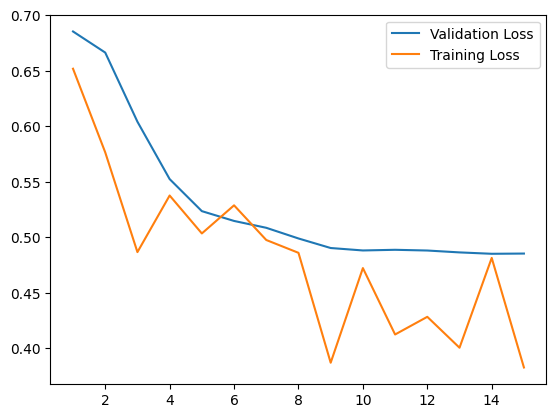

In [15]:
import matplotlib.pyplot as plt
iterations = []
for i in range(num_epochs):
    iterations.append(i+1)

plt.plot(iterations, validation_loss_list, label = 'Validation Loss')
plt.plot(iterations, training_loss_list, label = 'Training Loss')
plt.legend()

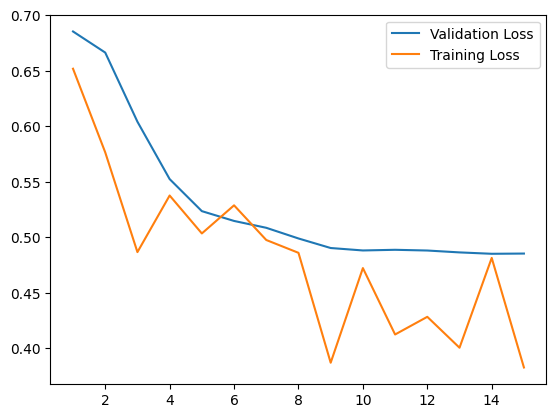

In [16]:
import matplotlib.pyplot as plt
iterations = []
for i in range(num_epochs):
    iterations.append(i+1)

plt.plot(iterations, validation_loss_list, label = 'Validation Loss')
plt.plot(iterations, training_loss_list, label = 'Training Loss')
plt.legend()

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score

test_loader = torch.utils.data.DataLoader(test_data, batch_size=20, shuffle=False)

model.to('cuda')
model.eval()

critereon = nn.CrossEntropyLoss()

# Initialize variables for evaluation
total_correct = 0
total_samples = 0
total_loss = 0.0
# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []
# Initialize lists to store misclassified images
misclassified_images = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        outputs = model(inputs)

        loss = critereon(outputs.logits, labels)
        total_loss += loss.item()

        _, predicted = torch.max(outputs.logits, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

        # Find misclassified images
        misclassified_idx = (predicted != labels).nonzero()
        misclassified_images.extend(inputs[misclassified_idx])


# Calculate evaluation metrics
# accuracy = total_correct / total_samples
average_loss = total_loss / len(test_loader)
accuracy = accuracy_score(predicted_labels, true_labels)

print(f'Accuracy on test set: {accuracy * 100:.2f}%')
print(f'Average loss on test set: {average_loss:.4f}')

100%|██████████| 67/67 [00:22<00:00,  2.93it/s]

Accuracy on test set: 80.87%
Average loss on test set: 0.5001


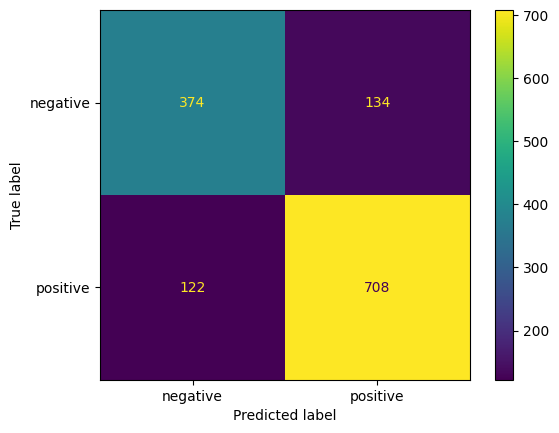

In [18]:
# Calculate the confusion matrix, Precision and Recall using scikit-learn
conf_matrix = confusion_matrix(true_labels, predicted_labels)
# precision = precision_score(true_labels, predicted_labels, average='micro')
# recall = recall_score(true_labels, predicted_labels, average='micro')


# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# Display the confusion matrix
display = ConfusionMatrixDisplay(conf_matrix, display_labels=train_data.classes)
display.plot()

In [19]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score



accuracy = accuracy_score(predicted_labels, true_labels)
print(f'Accuracy: {accuracy}')

report = classification_report(predicted_labels, true_labels)
print(f'Classification Report:\n{report}')

Accuracy: 0.8086696562032885
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.75      0.75       496
           1       0.85      0.84      0.85       842

    accuracy                           0.81      1338
   macro avg       0.79      0.80      0.80      1338
weighted avg       0.81      0.81      0.81      1338



In [21]:
torch.save(model.state_dict(), 'vit_weights.pth')

In [23]:
model.state_dict()

OrderedDict([('vit.embeddings.cls_token',
              tensor([[[-1.6077e-03,  6.1088e-03, -2.4317e-01,  2.9218e-04,  3.7795e-01,
                         4.5074e-02, -1.2905e-02,  1.1095e-02,  3.2594e-02, -2.0919e-01,
                        -6.2448e-03, -7.5497e-03, -9.1110e-03, -7.5560e-03, -1.1472e-02,
                        -4.7292e-03, -8.2632e-04,  6.3230e-02,  2.9355e-02, -5.3014e-03,
                        -5.2596e-02, -5.2491e-03, -5.0968e-03, -1.9449e-02, -1.0024e-03,
                         4.8867e-02,  2.5143e-03, -9.7462e-03,  3.8116e-02, -3.0073e-02,
                        -4.3068e-04,  1.6845e-02, -1.5461e-02,  7.6964e-03,  2.2460e-02,
                         2.5029e-03,  4.3944e-02,  3.2487e-03, -1.6432e-03,  7.4575e-03,
                         6.0840e-03,  7.8074e-03,  1.8559e-02,  4.3630e-03,  5.7553e-02,
                         4.0707e-01, -3.3665e-03,  1.0609e-02,  2.7977e-02, -1.5257e-03,
                        -9.0058e-03, -4.4542e-02,  5.5634e-03,  2.22